### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'

# Lecture Demo
#file_index='BBBSBBBB'

# Student ID
file_index='BSSSBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12249
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     14.9| 30.4132| -86.6635|       PRCP|US1FLOK0014|    38|[00 00 00 00 B0 5...|2009.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     5|[40 5A F0 5A 80 5...|1999.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     3|[20 5B 78 5B 48 5...|2000.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    40|[90 55 E0 54 A0 5...|2001.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    12|[E0 54 30 54 30 5...|2002.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USW00003882')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(11)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USW00003882'
11 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.4| 30.2119| -85.6828|       PRCP|USW00003882|     1|[00 00 34 5D 00 0...|1999.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       PRCP|USW00003882|     4|[00 42 00 00 00 0...|2000.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       PRCP|USW00003882|    28|[00 00 00 00 00 0...|2001.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       PRCP|USW00003882|     7|[10 58 40 55 00 0...|2002.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       PRCP|USW00003882|    16|[D0 56 80 50 80 4...|2003.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       PRCP|USW00003882|     9|[00 7E 00 7E 00 7...|2004.0|BSSSBSBS|
|      6.4| 30.2119| -85.68

(11, 365)

### Script for plotting yearly plots

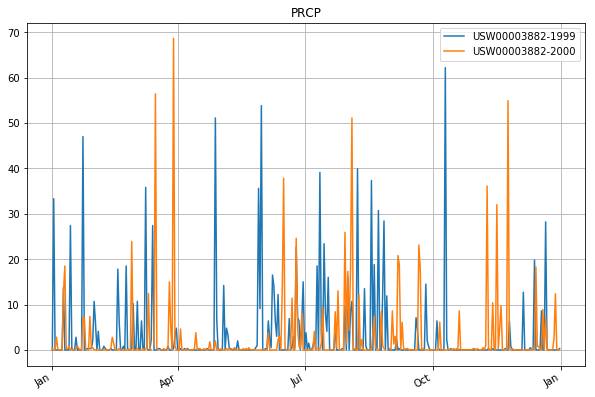

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax, labels=['USW00003882-1999','USW00003882-2000'],title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [18]:
def plot_pair(pair,func,labels):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis,labels)
    
def plot_valid(m,fig,axis,labels):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,labels=labels,title='valid-counts '+m)
    

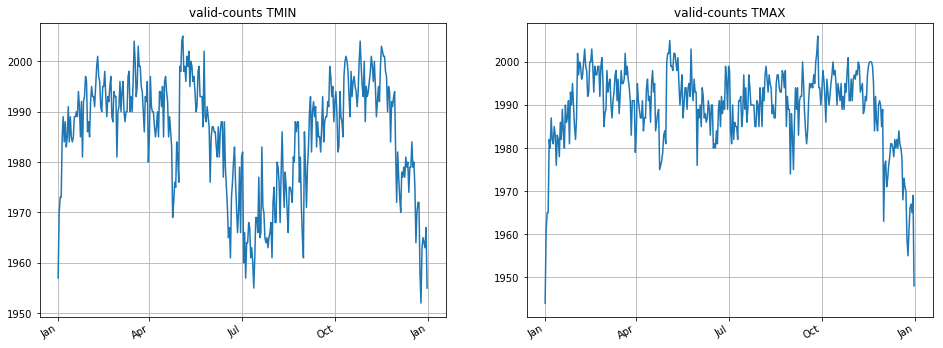

In [19]:
plot_pair(['TMIN','TMAX'],plot_valid,'')

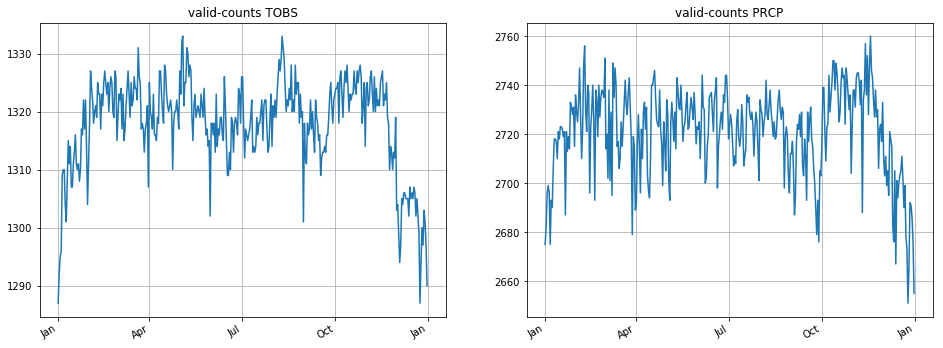

In [20]:
plot_pair(['TOBS','PRCP'],plot_valid,'')

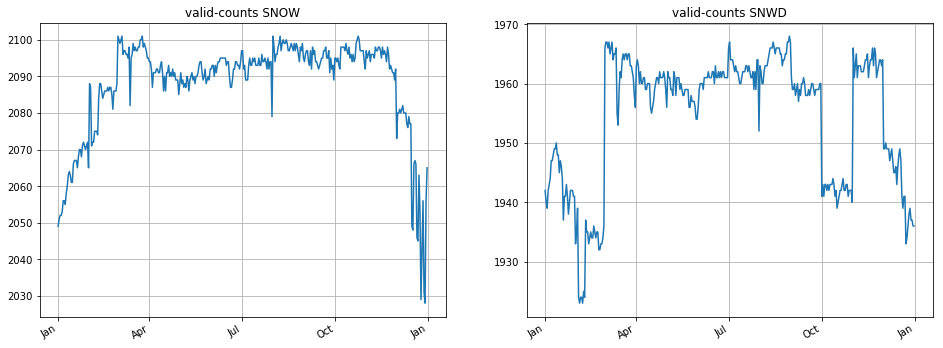

In [21]:
plot_pair(['SNOW', 'SNWD'],plot_valid,'')

### Plots of mean and std of observations

In [22]:
def plot_mean_std(m,fig,axis,labels):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,labels=labels,title='Mean+-std   '+m)

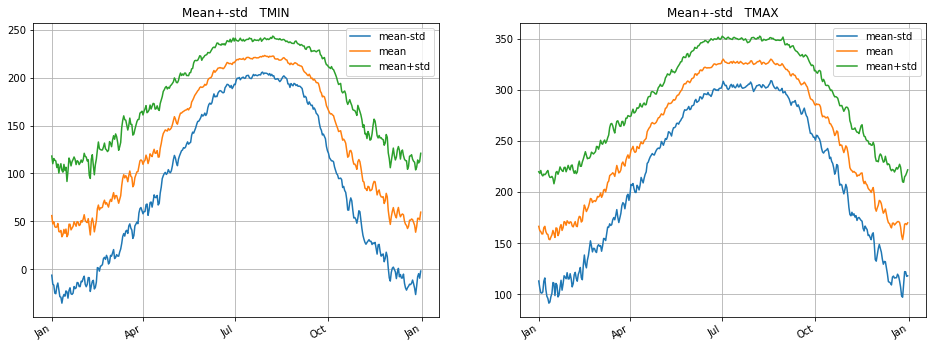

In [35]:
plot_pair(['TMIN','TMAX'],plot_mean_std, ['mean-std', 'mean', 'mean+std'])

mean of TOBS: 178.96269186
mean of PRCP: 36.4124495374


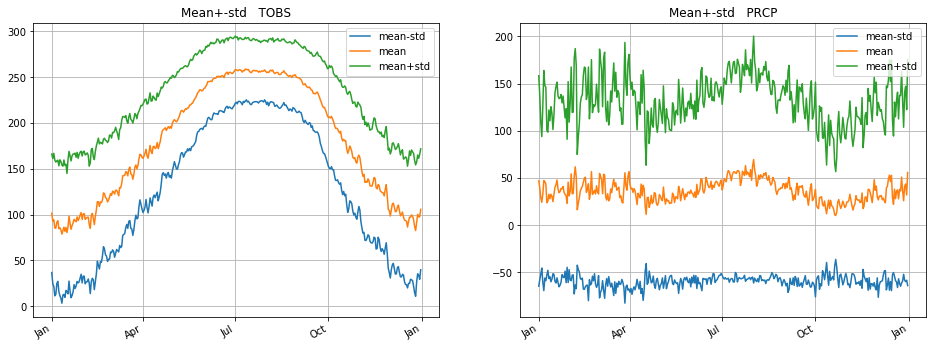

In [41]:
print 'mean of TOBS:', sum(STAT['TOBS']['Mean']) / len(STAT['TOBS']['Mean'])
print 'mean of PRCP:', sum(STAT['PRCP']['Mean']) / len(STAT['PRCP']['Mean'])

plot_pair(['TOBS','PRCP'],plot_mean_std, ['mean-std', 'mean', 'mean+std'])

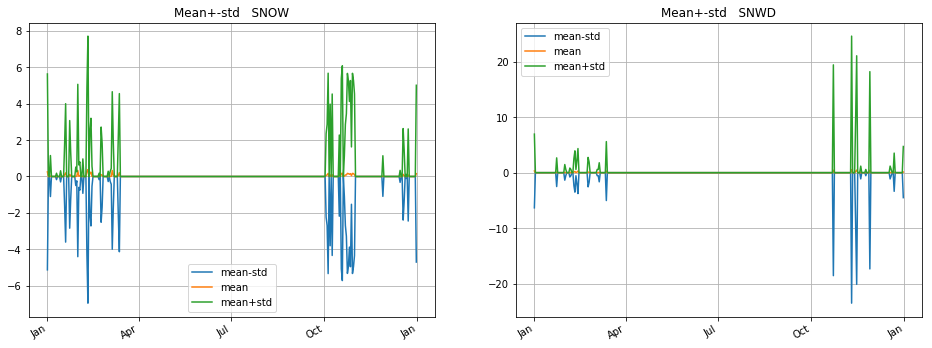

In [25]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std,['mean-std', 'mean', 'mean+std'])

In [43]:
#plot_pair(['PSUN', 'TSUN'],plot_mean_std,['mean-std', 'mean', 'mean+std'])

### plotting top 3 eigenvectors

In [26]:
def plot_eigen(m,fig,axis,labels):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,labels=labels,title='Top Eigenvectors '+m)

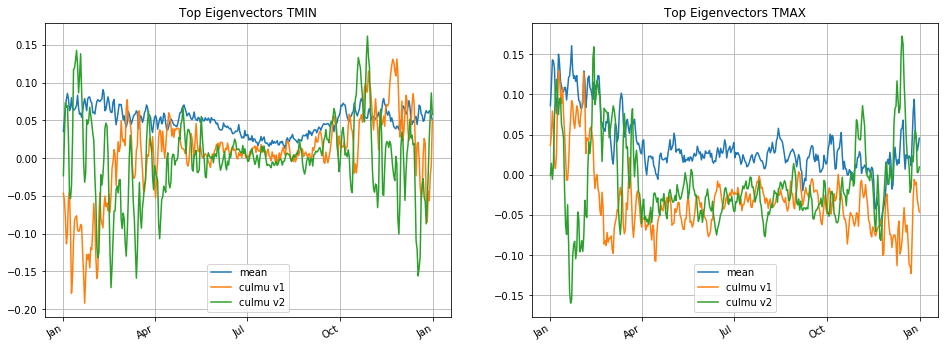

In [27]:
plot_pair(['TMIN','TMAX'],plot_eigen, ['mean', 'culmu v1', 'culmu v2'])

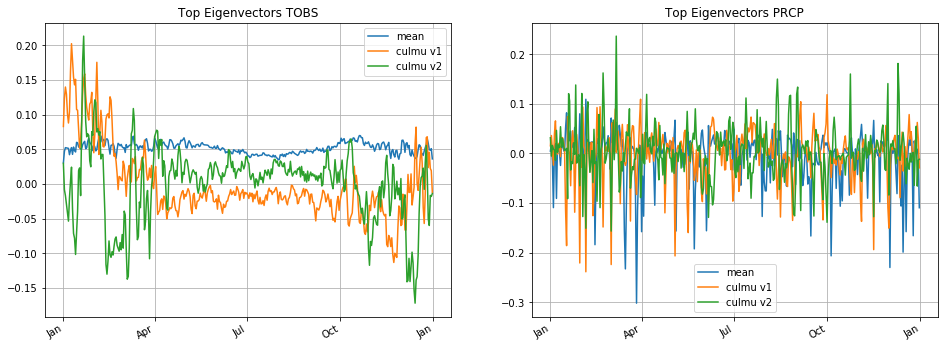

In [28]:
plot_pair(['TOBS','PRCP'],plot_eigen, ['mean', 'culmu v1', 'culmu v2'])

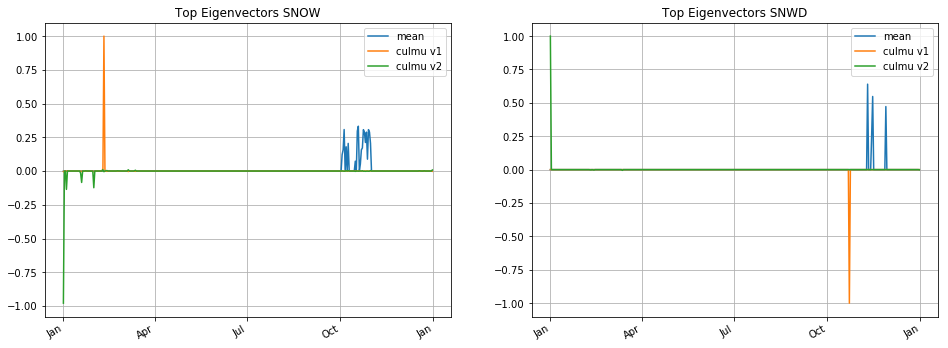

In [29]:
plot_pair(['SNOW', 'SNWD'],plot_eigen, ['mean', 'culmu v1', 'culmu v2'])

### Script for plotting percentage of variance explained

In [30]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

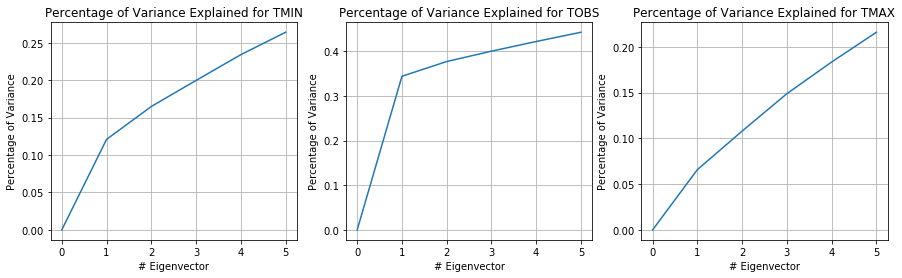

In [31]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

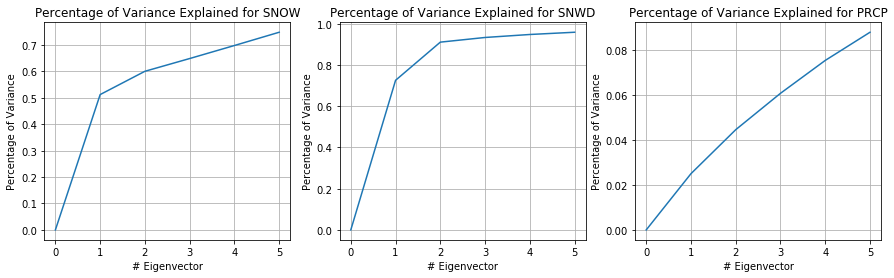

In [32]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
#sc.stop()